In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Recommendation Systems for Yelp Restaurant Reviews


For this Capstone Project, I will be building 3 Recommendation System Models to recommend restaurants based on Yelp Reviews in Toronto.

Firstly, to solve the user cold-start problem initially, I will build a **location-based recommendation system** that takes into account a user's geographical location (longitude, latitude) when he is using the app to recommend the top 10 nearby restaurants based on location proximity and overall review ratings.

After the user has started using my delivery app, I will build a **collaborative-filtering and a content-based recommendation system** that takes into account a user's previously visited restaurant and recommend 10 restaurants based on his past visits to restaurants.

The Collaborative Filtering system takes into account a user's super score rating on restaurants they have reviewed and leverages on a item-item cosine similarity matrix. The Content Based system takes into account keywords from a user's text review as well as restaurant categories to recommend similar restaurants.

In [ ]:
%cd /content/gdrive/MyDrive/recommender_system

/content/gdrive/MyDrive/recommender_system


In [ ]:
!pip install plotly_express

In [ ]:
## Importing Basic Packages

import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Importing Plotly Packages

import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

# Importing sklearn Packages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# Importing scipy Packages
from scipy.sparse.linalg import svds

In [ ]:
# Reading in Combined Reviews CSV File

final_reviews = pd.read_csv("clean_data/final_reviews.csv")
final_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(final_reviews.shape)
final_reviews.head(3)

(252420, 26)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,sentiment,Dominant_Topic,Keywords,Text_Chunks
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.0,0.0,0.0,0.0,"In the heart of Chinatown, I discovered it enr...",2017-06-06 19:04:10,2017.0,6.0,19:04:10,244.0,1442.0,4.709163,93.0,heart chinatown discovered enroute kensington ...,0.213835,0.532102,0.030,0.767,0.204,0.9942,positive,4.0,"food, order, place, price, fry, really, chicke...","['heart', 'chinatown', 'discover', 'market', '..."
1,9Eghhu_LzEJgDKNgisf3rg,iFEM16O5BeKvf_AHs6NzUQ,3.0,0.0,0.0,0.0,Was super excited to bring my boyfriend to thi...,2016-08-25 16:25:12,2016.0,8.0,16:25:12,233.0,1323.0,4.659483,92.0,super excited bring boyfriend scaddabush locat...,0.188048,0.440286,0.016,0.892,0.091,0.9381,neutral,0.0,"order, time, table, food, wait, service, ask, ...","['super', 'excited', 'bring', 'boyfriend', 'lo..."
2,jM6JjZXFAQQANwdlEwbH3g,IIE2OX5haarGNefY23R8BA,5.0,0.0,0.0,0.0,My absolutely favorite mushroom pizza in the c...,2016-04-23 03:32:19,2016.0,4.0,03:32:19,43.0,240.0,4.829268,13.0,absolutely favorite mushroom pizza city great ...,0.400000,0.690000,0.000,0.781,0.219,0.8930,positive,3.0,"great, place, food, love, service, friendly, s...","['absolutely', 'favorite', 'mushroom', 'pizza'..."


## Creating a Super-Score Rating

The first step to building our recommendation systems is to develop a rating score that reflects each user's overall preference for a restaurant. In our reviews dataset, we have the actual rating(stars) that users have indicated in their Yelp Reviews. However, we will try and build our **own Super Score rating** by combining these ratings with other sentiment scores like Textblob's `polarity` and VADER `compound` scores.

- The **polarity** of a text ranges from -1 to +1, negative to positive.
- The **subjectivity** score ranges from 0 to 1, very objective to very subjective. 
- The **compound** score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

Formula: **Super Score** = ``stars + (polarity x compound)``

In [ ]:
# Computing Super-Score Rating for Reviews

final_reviews['super_score'] = final_reviews['polarity'] *  final_reviews['compound']
final_reviews['super_score'] = final_reviews['super_score'] + final_reviews['stars']
final_reviews.sample(3)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,sentiment,Dominant_Topic,Keywords,Text_Chunks,super_score
235790,i--dxuKd_6Dx7mwgQ5nl-g,lY5oxaob4Ytdwa6kjMDJEA,1.0,2.0,1.0,0.0,"I do not usually write reviews on restaurants,...",2015-02-21 23:18:05,2015.0,2.0,23:18:05,549.0,3025.0,4.510055,230.0,usually write review restaurant serviceexperie...,-0.002231,0.506772,0.069,0.853,0.078,0.7633,negative,4.0,"food, order, place, price, fry, really, chicke...","['honestly', 'mexican', 'corn', 'usually', 'ch...",0.998297
43214,ckK6XX0o9xP5cKyAZzZO7w,nstxpg0KHOrPkpk6sJh9oA,4.0,1.0,0.0,0.0,Wow. Accepting the location was the same as th...,2019-07-13 01:22:53,2019.0,7.0,01:22:53,288.0,1716.0,4.927083,116.0,wow accepting location first unfortunate time ...,0.107483,0.401803,0.073,0.784,0.143,0.9657,positive,3.0,"great, place, food, love, service, friendly, s...","['stop', 'late', 'last', 'friendly', 'beer', '...",4.103796
170124,RqOgBMpKYdsEOmBVmFXe3g,CQWIFYTnMmYWjX_48gFJkw,5.0,0.0,0.0,0.0,So far the best I've had! First time here and ...,2016-08-14 16:30:10,2016.0,8.0,16:30:10,44.0,216.0,3.931818,13.0,far best ive first time got shoyu ramen corn g...,0.381250,0.479167,0.000,0.722,0.278,0.9471,positive,1.0,"sauce, noodle, flavour, pancake, sweet, taste,...","['captain', 'catch', 'restaurant', 'replace', ...",5.361082


In [ ]:
# Checking whether there are any rows with zero super scores

final_reviews[final_reviews['super_score']==0.0]

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,sentiment,Dominant_Topic,Keywords,Text_Chunks,super_score


In [ ]:
# Minimum Super Score Rating

final_reviews['super_score'].min()

0.1824

In [ ]:
# Maximum Super Score Rating

final_reviews['super_score'].max()

5.9752

The range of Super Score Ratings is from [0,6].

Recommender systems have a problem known as **user cold-start**, in which it is hard to provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.

For example, if I am new to a city or I am a new user of a food delivery app, it will be difficult to provide personal recommendations due to the lack of information about my own personal preferences with regards to food and restaurants.

With the cold-start problem, we have to give good recommendations to users that have provided no feedback. Essentially, their data is empty, and there are no relations that can be inferred for this user. The naive solution for this problem could be to first give a random recommendation, and for every following recommendation: **take feedback, retrain, sort the predicted ratings, and return the highest projected recommendation.**

One way where we can give a new user recommendations would be through **location proximity data.** Knowing a person's geographical location at the point of time where he is deciding to find new Restaurants to visit, we can use a **Location-Based Recommendation System** to recommend Restaurants near his/her vicinity. By providing an initial recommendation that is convenient for the user, we can attract him to start using our app and thereafter build on his initial preference to recommend other restaurants using our other alternative Recommendation Systems.

# Location-Based Recommendation System

In [ ]:
# Reading in Restaurant Businesses Final CSV File

business_final = pd.read_csv("clean_data/business_final.csv")
business_final.drop(['Unnamed: 0'], axis=1, inplace = True)
print(business_final.shape)
business_final.head(3)

(5471, 12)


,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code,key
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,Toronto,ON,4.0,116,"Vietnamese, Restaurants",43.666376,-79.348773,1,M4M 1Y3,0QjROMVW9ACKjhSEfHqNCQ
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,Toronto,ON,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",43.649859,-79.382060,1,M5H 3V9,8k62wYhDVq1-652YbJi5eg
2,PYLv9n0y8MimzTK2zCBoFw,GIG@bites Internet Cafe,Toronto,ON,3.0,4,"Home Services, Shopping, IT Services & Compute...",43.664707,-79.413939,1,M6G,PYLv9n0y8MimzTK2zCBoFw


In [ ]:
# Filtering for Selected Columns

business_final['business_id'] = business_final['business_id ']
business_final = business_final[['business_id', 'name', 'categories','stars','review_count','latitude','longitude','postal_code']]
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,"Vietnamese, Restaurants",4.0,116,43.666376,-79.348773,M4M 1Y3
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",3.0,8,43.649859,-79.382060,M5H 3V9
2,PYLv9n0y8MimzTK2zCBoFw,GIG@bites Internet Cafe,"Home Services, Shopping, IT Services & Compute...",3.0,4,43.664707,-79.413939,M6G
3,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,"Fast Food, Restaurants, Chicken Shop",3.0,11,43.765279,-79.326248,M3A 1Z3
4,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,"Coffee & Tea, Restaurants, Sandwiches, Food",4.5,24,43.685608,-79.313936,M4C 1J6


In [ ]:
# Geographical Overview of Restaurants in Toronto City

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

## K-Means Clustering

Based on the above visualization, we can see that there are areas in Toronto where there is a high density of Restaurants while there are also other areas that have fewer Restaurants. Depending on where a user is currently located, it would make sense to recommend restaurants that are close to his location regardless of where he is in a city.

Hence, one way where we can group restaurants together based on geographical location is using the K-Means Clustering Algorithm. The **K-Means algorithm** predicts the cluster where the user is located in and pulls out this cluster’s top 10 restaurants and recommends them to him.

In [ ]:
# Putting the Coordinates of Restaurants together into a dataframe
coordinates = business_final[['longitude','latitude']]
coordinates # Total of 5,471 Locations for 5,471 Unique Restaurants

,longitude,latitude
0,-79.348773,43.666376
1,-79.382060,43.649859
2,-79.413939,43.664707
3,-79.326248,43.765279
4,-79.313936,43.685608
...,...,...
5466,-79.396762,43.700617
5467,-79.480365,43.726656
5468,-79.402098,43.657716
5469,-79.575135,43.701807


In [ ]:
# Elbow method to determine the number of K in Kmeans Clustering

distortions = []
K = range(1,15)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coordinates)
    distortions.append(kmeansModel.inertia_)

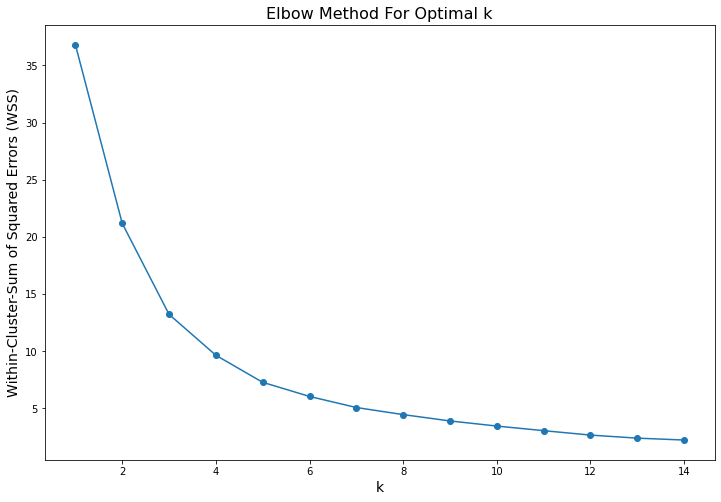

In [ ]:
# Elbow Graph for WSS

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 16)
plt.show()

For the **Elbow Method**, we calculate the **Within-Cluster-Sum of Squared Errors (WSS)** for different values of k, and choose the k for which WSS first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow. Based on the above figure, the optimal **k = 4 (clusters).**

In [ ]:
# Silhouette Score Method to to determine the number of K in Kmeans Clustering

sil = []
kmax = 25

# Dissimilarity would not be defined for a single cluster. Minimum number of clusters should be 2

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

In [ ]:
# Silhouette Scores

sil

[0.5269621438963676,
 0.5113690668271879,
 0.5391444258451977,
 0.49742518693533444,
 0.45269671967123454,
 0.4589208935476628,
 0.4556318462381218,
 0.4603654269862582,
 0.41448634703761167,
 0.42702047390489756,
 0.4380121725586534,
 0.4397321060204696,
 0.44464570538227144,
 0.4128928036877588,
 0.4134572776358978,
 0.41486210953363867,
 0.4204714634111184,
 0.4130821751716791,
 0.4257272870777673,
 0.4245572558973431,
 0.4272043023347027,
 0.425551212862187,
 0.42375552943146155,
 0.4149844235388519]

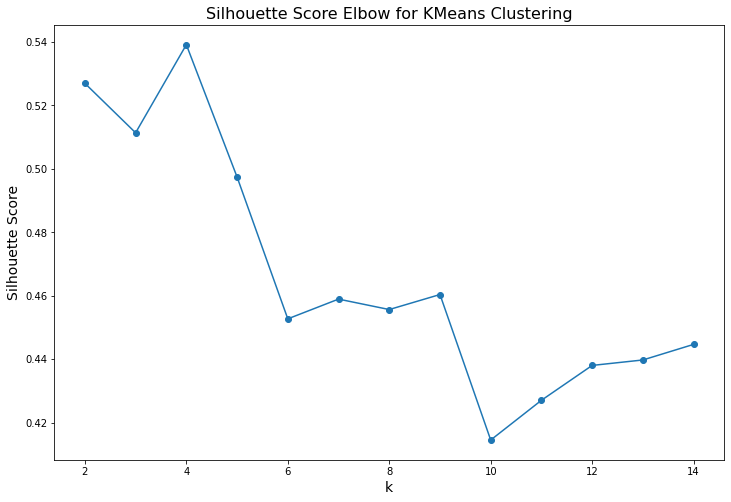

In [ ]:
# Elbow Graph for Silhouette Score

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K[1:15], sil[:13], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

The **Silhouette Score** measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The Silhouette Score reaches its **global maximum** at the **optimal k.** 
 Starting from 2 clusters, the optimal k based on the above Silhouette Scores would be **k = 4 (clusters).**

In [ ]:
# Setting K = 4

kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

k = 4  silhouette_score  0.5391444258451977


In [ ]:
business_final['init_cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,"Vietnamese, Restaurants",4.0,116,43.666376,-79.348773,M4M 1Y3,2
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",3.0,8,43.649859,-79.382060,M5H 3V9,2
2,PYLv9n0y8MimzTK2zCBoFw,GIG@bites Internet Cafe,"Home Services, Shopping, IT Services & Compute...",3.0,4,43.664707,-79.413939,M6G,2
3,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,"Fast Food, Restaurants, Chicken Shop",3.0,11,43.765279,-79.326248,M3A 1Z3,1
4,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,"Coffee & Tea, Restaurants, Sandwiches, Food",4.5,24,43.685608,-79.313936,M4C 1J6,1


In [ ]:
# Geographical Plot of 4 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="init_cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

Based on the above plot, we see that even though there are 4 clusters, the less dense regions have restaurants within clusters that are spread out across long distances. Hence, this might dissuade users from visiting the restaurants that we have recommended if they are too far from his location.

While 4 clusters might seem optimal, in this case, it would be better to have more clusters that are smaller and more spread out across the city of Toronto.

In [ ]:
# Let's try k = 10

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 10", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

k = 10  silhouette_score  0.47216261664940357


In [ ]:
business_final['cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,"Vietnamese, Restaurants",4.0,116,43.666376,-79.348773,M4M 1Y3,2,1
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",3.0,8,43.649859,-79.382060,M5H 3V9,2,0
2,PYLv9n0y8MimzTK2zCBoFw,GIG@bites Internet Cafe,"Home Services, Shopping, IT Services & Compute...",3.0,4,43.664707,-79.413939,M6G,2,5
3,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,"Fast Food, Restaurants, Chicken Shop",3.0,11,43.765279,-79.326248,M3A 1Z3,1,6
4,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,"Coffee & Tea, Restaurants, Sandwiches, Food",4.5,24,43.685608,-79.313936,M4C 1J6,1,1


In [ ]:
# Geographical Plot of 10 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=800)

fig.update_layout(mapbox_style="dark")
fig.show()

Toronto's total land area is **630.2 km²**, as such having more clusters would allow our Location-Based Recommendation System to recommend users restaurants that are at a closer proximity to their own geographical location.

Apart from recommending restaurants that are close to a user, it is also important that the recommended restaurannts have a **rating that is as high as possible.** Restaurants that have an overall higher rating (star) generally translates to **better customer experience** which will improve user's customer satisfaction of using our recommendationn system.

In [ ]:
# Sort Restaurants based on Stars(rating) and subsequently by Review_count

top_restaurants_toronto = business_final.sort_values(by=['stars', 'review_count'], ascending=False)
top_restaurants_toronto.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
1004,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",5.0,317,43.744703,-79.346468,M3B 2W7,1,6
3897,J9vAdD2dCpFuGsxPIn184w,New Orleans Seafood & Steakhouse,"Steakhouses, Cajun/Creole, Restaurants, Seafood",5.0,122,43.677744,-79.506248,M6N 4L1,0,3
570,JB8-8TtNYX-vLqN7cz-zHA,Zeal Burgers,"Restaurants, Burgers",5.0,103,43.700356,-79.517524,M9N 1W2,0,9
13,VUADGMPLJoWqhHb1G4LIcA,Veghed,"Vegan, Restaurants, Vegetarian",5.0,71,43.649166,-79.422498,M6J 1X3,2,5
662,FM0h7JHdthhnc50vgGWzpA,I'll Be Seeing You,"Cocktail Bars, Bars, Comfort Food, Wine Bars, ...",5.0,49,43.658993,-79.348074,M4M 1H3,2,1


In [ ]:
top_restaurants_toronto

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
1004,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",5.0,317,43.744703,-79.346468,M3B 2W7,1,6
3897,J9vAdD2dCpFuGsxPIn184w,New Orleans Seafood & Steakhouse,"Steakhouses, Cajun/Creole, Restaurants, Seafood",5.0,122,43.677744,-79.506248,M6N 4L1,0,3
570,JB8-8TtNYX-vLqN7cz-zHA,Zeal Burgers,"Restaurants, Burgers",5.0,103,43.700356,-79.517524,M9N 1W2,0,9
13,VUADGMPLJoWqhHb1G4LIcA,Veghed,"Vegan, Restaurants, Vegetarian",5.0,71,43.649166,-79.422498,M6J 1X3,2,5
662,FM0h7JHdthhnc50vgGWzpA,I'll Be Seeing You,"Cocktail Bars, Bars, Comfort Food, Wine Bars, ...",5.0,49,43.658993,-79.348074,M4M 1H3,2,1
...,...,...,...,...,...,...,...,...,...,...
4083,3VG1kauULRxmq8N_g4s-FQ,KFC,"Chicken Shop, Fast Food, Restaurants, American...",1.0,3,43.656224,-79.435584,M6H 4B1,2,5
4213,7BYxi0QH37GDOt6-y_WNGA,Ko Burgers,"Burgers, Restaurants",1.0,3,43.692573,-79.283083,M1L 1C1,1,1
4486,lhERIwIdVIE-yB_1P7utVg,Food Monks,"Home Services, Electricians, Plumbing, Food De...",1.0,3,43.829632,-79.254021,M1V 5G4,1,4
4718,YfAn2K4VSY-4sIo_CTRpjQ,Ice Queen Restaurant,Restaurants,1.0,3,43.639852,-79.446919,M6R 2K3,2,5


In [ ]:
# Creating Location-Based Recommendation Function
def location_based_recommendation(df, latitude, longitude):
    
    """Predict the cluster for longitude and latitude provided"""
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print("This restaurant belongs to cluster:", cluster)
   
    """Get the best restaurant in this cluster along with the relevant information for a user to make a decision"""
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','categories','stars', 'review_count','cluster']]

In [ ]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [43.6677, 43.6701, 43.6546],
    'longitude' : [-79.3948, -79.2988, -79.4452],
}

test_df = pd.DataFrame(test_coordinates)


In [ ]:
user1 = test_df[test_df['user'] == 1]
user1

,user,latitude,longitude
0,1,43.6677,-79.3948


In [ ]:
user1.latitude

0    43.6677
Name: latitude, dtype: float64

In [ ]:
top_restaurants_toronto

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
1004,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",5.0,317,43.744703,-79.346468,M3B 2W7,1,6
3897,J9vAdD2dCpFuGsxPIn184w,New Orleans Seafood & Steakhouse,"Steakhouses, Cajun/Creole, Restaurants, Seafood",5.0,122,43.677744,-79.506248,M6N 4L1,0,3
570,JB8-8TtNYX-vLqN7cz-zHA,Zeal Burgers,"Restaurants, Burgers",5.0,103,43.700356,-79.517524,M9N 1W2,0,9
13,VUADGMPLJoWqhHb1G4LIcA,Veghed,"Vegan, Restaurants, Vegetarian",5.0,71,43.649166,-79.422498,M6J 1X3,2,5
662,FM0h7JHdthhnc50vgGWzpA,I'll Be Seeing You,"Cocktail Bars, Bars, Comfort Food, Wine Bars, ...",5.0,49,43.658993,-79.348074,M4M 1H3,2,1
...,...,...,...,...,...,...,...,...,...,...
4083,3VG1kauULRxmq8N_g4s-FQ,KFC,"Chicken Shop, Fast Food, Restaurants, American...",1.0,3,43.656224,-79.435584,M6H 4B1,2,5
4213,7BYxi0QH37GDOt6-y_WNGA,Ko Burgers,"Burgers, Restaurants",1.0,3,43.692573,-79.283083,M1L 1C1,1,1
4486,lhERIwIdVIE-yB_1P7utVg,Food Monks,"Home Services, Electricians, Plumbing, Food De...",1.0,3,43.829632,-79.254021,M1V 5G4,1,4
4718,YfAn2K4VSY-4sIo_CTRpjQ,Ice Queen Restaurant,Restaurants,1.0,3,43.639852,-79.446919,M6R 2K3,2,5


In [ ]:
# Top 10 Recommended Restaurants based on Location at Royal Ontario Museum

location_based_recommendation(top_restaurants_toronto, user1.latitude, user1.longitude)

This restaurant belongs to cluster: 0


,name,latitude,longitude,categories,stars,review_count,cluster
849,Big Trouble Pizza,43.651328,-79.397038,"Pizza, Restaurants",5.0,48,0
3234,Mallo,43.664631,-79.410738,"Coffee & Tea, Food, Cafes, Nightlife, Sandwich...",5.0,36,0
5178,Ooshee Mediterranean Oven,43.668469,-79.386778,"Restaurants, Mediterranean, Bakeries, Lebanese...",5.0,20,0
3037,The Vegan Extremist,43.656321,-79.402501,"Indian, Vegan, Restaurants",5.0,15,0
1900,Muncheez,43.644059,-79.403310,"Juice Bars & Smoothies, Restaurants, Creperies...",5.0,12,0
5426,Strange Love Coffee,43.647247,-79.403050,"Coffee & Tea Supplies, Coffee Roasteries, Food...",5.0,11,0
363,Fast Fresh Foods,43.657823,-79.384715,"Restaurants, Salad, Sandwiches, Food",5.0,8,0
1667,Casamiento,43.654775,-79.402205,"Latin American, Pop-up Shops, Salvadoran, Shop...",5.0,8,0
3023,Old Town Bodega,43.654212,-79.361035,"Cafes, Restaurants, Food, Coffee & Tea",5.0,8,0
3629,YEE: Gettin' Cozy with Butter Chicken Roti,43.650860,-79.369668,"Local Flavor, Restaurants, Indian, Yelp Events",5.0,8,0


In [ ]:
# Geographical Plot of Nearby Recommended Restaurants from Royal Ontario Museum

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(location_based_recommendation(top_restaurants_toronto, user1.latitude, user1.longitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1000, height=700, hover_data= ['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count'])
fig.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))
fig.update_layout(mapbox_style="dark")

This restaurant belongs to cluster: 0


# Collaborative-Filtering Recommendation System


**Collaborative filtering** is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

## Creating User-Item Matrix

In [ ]:
final_reviews.head(3)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,sentiment,Dominant_Topic,Keywords,Text_Chunks,super_score
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.0,0.0,0.0,0.0,"In the heart of Chinatown, I discovered it enr...",2017-06-06 19:04:10,2017.0,6.0,19:04:10,244.0,1442.0,4.709163,93.0,heart chinatown discovered enroute kensington ...,0.213835,0.532102,0.030,0.767,0.204,0.9942,positive,4.0,"food, order, place, price, fry, really, chicke...","['heart', 'chinatown', 'discover', 'market', '...",4.212595
1,9Eghhu_LzEJgDKNgisf3rg,iFEM16O5BeKvf_AHs6NzUQ,3.0,0.0,0.0,0.0,Was super excited to bring my boyfriend to thi...,2016-08-25 16:25:12,2016.0,8.0,16:25:12,233.0,1323.0,4.659483,92.0,super excited bring boyfriend scaddabush locat...,0.188048,0.440286,0.016,0.892,0.091,0.9381,neutral,0.0,"order, time, table, food, wait, service, ask, ...","['super', 'excited', 'bring', 'boyfriend', 'lo...",3.176407
2,jM6JjZXFAQQANwdlEwbH3g,IIE2OX5haarGNefY23R8BA,5.0,0.0,0.0,0.0,My absolutely favorite mushroom pizza in the c...,2016-04-23 03:32:19,2016.0,4.0,03:32:19,43.0,240.0,4.829268,13.0,absolutely favorite mushroom pizza city great ...,0.400000,0.690000,0.000,0.781,0.219,0.8930,positive,3.0,"great, place, food, love, service, friendly, s...","['absolutely', 'favorite', 'mushroom', 'pizza'...",5.357200


In [ ]:
business_final.head(3)

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,"Vietnamese, Restaurants",4.0,116,43.666376,-79.348773,M4M 1Y3,2,1
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",3.0,8,43.649859,-79.382060,M5H 3V9,2,0
2,PYLv9n0y8MimzTK2zCBoFw,GIG@bites Internet Cafe,"Home Services, Shopping, IT Services & Compute...",3.0,4,43.664707,-79.413939,M6G,2,5


In [ ]:
# Filtering for Selected Columns

final_df = final_reviews[['business_id', 'user_id', 'super_score', 'Keywords', 'stars']]
final_df.head(3)

,business_id,user_id,super_score,Keywords,stars
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.212595,"food, order, place, price, fry, really, chicke...",4.0
1,9Eghhu_LzEJgDKNgisf3rg,iFEM16O5BeKvf_AHs6NzUQ,3.176407,"order, time, table, food, wait, service, ask, ...",3.0
2,jM6JjZXFAQQANwdlEwbH3g,IIE2OX5haarGNefY23R8BA,5.357200,"great, place, food, love, service, friendly, s...",5.0


In [ ]:
toronto_restaurant = business_final[['business_id', 'name', 'categories']]
toronto_restaurant.head()

,business_id,name,categories
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,"Vietnamese, Restaurants"
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res..."
2,PYLv9n0y8MimzTK2zCBoFw,GIG@bites Internet Cafe,"Home Services, Shopping, IT Services & Compute..."
3,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,"Fast Food, Restaurants, Chicken Shop"
4,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,"Coffee & Tea, Restaurants, Sandwiches, Food"


In [ ]:
# Merging Dataframes

toronto_data = pd.merge(final_df, toronto_restaurant, on='business_id')
toronto_data.head(5)

,business_id,user_id,super_score,Keywords,stars,name,categories
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.212595,"food, order, place, price, fry, really, chicke...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants"
1,qUWqjjjfpB2-4P3He5rsKw,Nq6e5N8bjgD9B46O4va_zA,4.490087,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants"
2,qUWqjjjfpB2-4P3He5rsKw,wPLEzIlIUnTgc0lkJL_TmQ,4.187629,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants"
3,qUWqjjjfpB2-4P3He5rsKw,TX5kwQLpKUDvNf4mfdaH3Q,5.260131,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants"
4,qUWqjjjfpB2-4P3He5rsKw,fSYQ_oQ0wNGk2nMJLvNZJA,5.324200,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants"


In [ ]:
toronto_data.head()

,business_id,user_id,super_score,Keywords,stars,name,categories
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.212595,"food, order, place, price, fry, really, chicke...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants"
1,qUWqjjjfpB2-4P3He5rsKw,Nq6e5N8bjgD9B46O4va_zA,4.490087,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants"
2,qUWqjjjfpB2-4P3He5rsKw,wPLEzIlIUnTgc0lkJL_TmQ,4.187629,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants"
3,qUWqjjjfpB2-4P3He5rsKw,TX5kwQLpKUDvNf4mfdaH3Q,5.260131,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants"
4,qUWqjjjfpB2-4P3He5rsKw,fSYQ_oQ0wNGk2nMJLvNZJA,5.324200,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants"


In [ ]:
#toronto_data.to_csv("clean_data/toronto_data2.csv")

In [ ]:
# Combining the text in Keywords and categories columns
toronto_data['All_Keywords'] = toronto_data['categories'].str.cat(toronto_data['Keywords'],sep=", ")
toronto_data.head()

,business_id,user_id,super_score,Keywords,stars,name,categories,All_Keywords
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.212595,"food, order, place, price, fry, really, chicke...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, food, orde..."
1,qUWqjjjfpB2-4P3He5rsKw,Nq6e5N8bjgD9B46O4va_zA,4.490087,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, great, pla..."
2,qUWqjjjfpB2-4P3He5rsKw,wPLEzIlIUnTgc0lkJL_TmQ,4.187629,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, great, pla..."
3,qUWqjjjfpB2-4P3He5rsKw,TX5kwQLpKUDvNf4mfdaH3Q,5.260131,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, food, orde..."
4,qUWqjjjfpB2-4P3He5rsKw,fSYQ_oQ0wNGk2nMJLvNZJA,5.324200,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, food, orde..."


In [ ]:
# Sanity Check
toronto_data.All_Keywords.head(1)

0    Pizza, Italian, Salad, Restaurants, food, orde...
Name: All_Keywords, dtype: object

In [ ]:
# Top Restaurants in Toronto based on Super Score Rating
toronto_data.groupby('name')['super_score'].mean().sort_values(ascending = False).head()

name
Sabor Del Pacifico    5.650667
Sidewalk              5.509265
Ajwa Pizza            5.491135
Hot Dog Stand         5.474419
Dasoni                5.471066
Name: super_score, dtype: float64

The Restaurant with the **Highest Super Score Rating** in Toronto is `Sabor Del Pacifico`.

In [ ]:
# Restaurants in Toronto with the highest number of Yelp Reviews
toronto_data.groupby('name')['super_score'].count().sort_values(ascending = False).head()

name
Pai Northern Thai Kitchen            2694
Uncle Tetsu's Japanese Cheesecake    1100
Seven Lives Tacos Y Mariscos         1077
KINKA IZAKAYA ORIGINAL               1004
Banh Mi Boys                          983
Name: super_score, dtype: int64

The Restaurant with the **Highest number of Yelp Reviews** in Toronto is `Pai Northern Thai Kitchen`.

In [ ]:
# Creating the Matrix by using the Pivot Table Function
toronto_restaurant_rating = toronto_data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
toronto_restaurant_rating.head()

name,'ONO Poké Bar,00 Gelato,0109 Dessert & Chocolate,1 Plus 2 Pizza & Wings,100 Percent Korean,12 Tables,120 Diner,1915 Lan Zhou Ramen,2 Bros Cuisine,241 Pizza,241 pizza,3 Brasseurs,3 Eggs All Day Pub & Grill,3 Kings Cafe & Shisha Lounge,3030,309 Dhaba Indian Excellence,32 Chicken St.,330 Takeout,360 Restaurant,3SK Cafe,416 Snack Bar,4C Broast Chicken,5 Elements Espresso Bar,5 Spice Dining,521 Cafe & Bar,...,Zen Sanuki Udon,ZenQ,Zeytouna,Zezafoun Syrian Cuisine,Zhang's Kitchen,Zheng's Juicy Fried Buns,Ziggy's Middle Eastern & Vegetarian Foods,Zoup!,Zucca Trattoria,Zuki Japanese Restaurant,deKEFIR,est Restaurant,gourmet kitchen,holts café,iBento,iQ,iQ Food,illstyl3 Sammies,illy Caffè,kibo sushi house,kings drive in,pico de gallo,subway,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--7gjElmOrthETJ8XqzMBw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--BumyUHiO_7YsHurb9Hkw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--C93xIlmjtgQfSOIpcQSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--DKDJlRHfsvufdGSk_Sdw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--EVSb3jbKVL3WJ5NUCuCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Normalizing the Rating Scores

def mean_center_rows(df):
    return (df.T - df.mean(axis = 1)).T

toronto_restaurant_rating = mean_center_rows(toronto_restaurant_rating)
toronto_restaurant_rating.head()

name,'ONO Poké Bar,00 Gelato,0109 Dessert & Chocolate,1 Plus 2 Pizza & Wings,100 Percent Korean,12 Tables,120 Diner,1915 Lan Zhou Ramen,2 Bros Cuisine,241 Pizza,241 pizza,3 Brasseurs,3 Eggs All Day Pub & Grill,3 Kings Cafe & Shisha Lounge,3030,309 Dhaba Indian Excellence,32 Chicken St.,330 Takeout,360 Restaurant,3SK Cafe,416 Snack Bar,4C Broast Chicken,5 Elements Espresso Bar,5 Spice Dining,521 Cafe & Bar,...,Zen Sanuki Udon,ZenQ,Zeytouna,Zezafoun Syrian Cuisine,Zhang's Kitchen,Zheng's Juicy Fried Buns,Ziggy's Middle Eastern & Vegetarian Foods,Zoup!,Zucca Trattoria,Zuki Japanese Restaurant,deKEFIR,est Restaurant,gourmet kitchen,holts café,iBento,iQ,iQ Food,illstyl3 Sammies,illy Caffè,kibo sushi house,kings drive in,pico de gallo,subway,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--7gjElmOrthETJ8XqzMBw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--BumyUHiO_7YsHurb9Hkw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--C93xIlmjtgQfSOIpcQSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--DKDJlRHfsvufdGSk_Sdw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--EVSb3jbKVL3WJ5NUCuCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filling all Null Values with 0.0

toronto_restaurant_rating = toronto_restaurant_rating.fillna(0)
toronto_restaurant_rating.head()

name,'ONO Poké Bar,00 Gelato,0109 Dessert & Chocolate,1 Plus 2 Pizza & Wings,100 Percent Korean,12 Tables,120 Diner,1915 Lan Zhou Ramen,2 Bros Cuisine,241 Pizza,241 pizza,3 Brasseurs,3 Eggs All Day Pub & Grill,3 Kings Cafe & Shisha Lounge,3030,309 Dhaba Indian Excellence,32 Chicken St.,330 Takeout,360 Restaurant,3SK Cafe,416 Snack Bar,4C Broast Chicken,5 Elements Espresso Bar,5 Spice Dining,521 Cafe & Bar,...,Zen Sanuki Udon,ZenQ,Zeytouna,Zezafoun Syrian Cuisine,Zhang's Kitchen,Zheng's Juicy Fried Buns,Ziggy's Middle Eastern & Vegetarian Foods,Zoup!,Zucca Trattoria,Zuki Japanese Restaurant,deKEFIR,est Restaurant,gourmet kitchen,holts café,iBento,iQ,iQ Food,illstyl3 Sammies,illy Caffè,kibo sushi house,kings drive in,pico de gallo,subway,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--7gjElmOrthETJ8XqzMBw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--BumyUHiO_7YsHurb9Hkw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--C93xIlmjtgQfSOIpcQSA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--DKDJlRHfsvufdGSk_Sdw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--EVSb3jbKVL3WJ5NUCuCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Check Mean scores across user_ids

toronto_restaurant_rating.mean(axis=1)

user_id
--7gjElmOrthETJ8XqzMBw   -2.086395e-19
--BumyUHiO_7YsHurb9Hkw    8.867179e-18
--C93xIlmjtgQfSOIpcQSA    0.000000e+00
--DKDJlRHfsvufdGSk_Sdw    0.000000e+00
--EVSb3jbKVL3WJ5NUCuCA    0.000000e+00
                              ...     
zzmhLxcZ4XZQyz95c_KbOA    4.172790e-19
zzo--VpSQh8PpsGVeMC1dQ   -3.129593e-19
zztkCqqgR6VntYbqio4UTQ    0.000000e+00
zzwTJAgONYCTeJia4te47g    0.000000e+00
zzyMMeUZzKAy7KQhM7lU2w   -1.043198e-19
Length: 74515, dtype: float64

In [ ]:
toronto_restaurant_rating.mean(axis=1).isnull().sum()

0

In [ ]:
# Check Mean scores across business_ids
toronto_restaurant_rating.mean(axis = 0)

name
'ONO Poké Bar                   0.000219
00 Gelato                       0.000213
0109 Dessert & Chocolate       -0.000495
1 Plus 2 Pizza & Wings         -0.000073
100 Percent Korean              0.001132
                                  ...   
kings drive in                  0.000006
pico de gallo                  -0.000004
subway                         -0.000093
yuan yuan Chinese Restaurant    0.000012
z-teca Gourmet Burritos        -0.000492
Length: 4257, dtype: float64

In [ ]:
toronto_restaurant_rating.mean(axis = 0).isnull().sum()

0

## Cosine Similarity


The cosine similarity between the user profile and all item profiles is computed to establish each user's preference. Cosine similarity measures the similarity between two vectors by calculating the cosine of the angle between them. It is the dot product of two vectors divided by the product of the magnitude of each vector. As the dot product is divided by the magnitude, data is normalised and only the angle difference is measured. The cosine similarity of each restaurant to each user is calculated. The cosine of a 0 degree angle is 1, therefore the closer to 1 the cosine similarity is, the more similar the items are.

In [ ]:
# Overview of Matrix - #74,515 rows of User_ids, 4,257 columns of Restaurants

print(toronto_restaurant_rating.shape)
toronto_restaurant_rating

(74515, 4257)


name,'ONO Poké Bar,00 Gelato,0109 Dessert & Chocolate,1 Plus 2 Pizza & Wings,100 Percent Korean,12 Tables,120 Diner,1915 Lan Zhou Ramen,2 Bros Cuisine,241 Pizza,241 pizza,3 Brasseurs,3 Eggs All Day Pub & Grill,3 Kings Cafe & Shisha Lounge,3030,309 Dhaba Indian Excellence,32 Chicken St.,330 Takeout,360 Restaurant,3SK Cafe,416 Snack Bar,4C Broast Chicken,5 Elements Espresso Bar,5 Spice Dining,521 Cafe & Bar,...,Zen Sanuki Udon,ZenQ,Zeytouna,Zezafoun Syrian Cuisine,Zhang's Kitchen,Zheng's Juicy Fried Buns,Ziggy's Middle Eastern & Vegetarian Foods,Zoup!,Zucca Trattoria,Zuki Japanese Restaurant,deKEFIR,est Restaurant,gourmet kitchen,holts café,iBento,iQ,iQ Food,illstyl3 Sammies,illy Caffè,kibo sushi house,kings drive in,pico de gallo,subway,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--7gjElmOrthETJ8XqzMBw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--BumyUHiO_7YsHurb9Hkw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--C93xIlmjtgQfSOIpcQSA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--DKDJlRHfsvufdGSk_Sdw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--EVSb3jbKVL3WJ5NUCuCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzmhLxcZ4XZQyz95c_KbOA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzo--VpSQh8PpsGVeMC1dQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zztkCqqgR6VntYbqio4UTQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Converting the Matrix DataFrame into a NumPy array

toronto_matrix = toronto_restaurant_rating.to_numpy()
toronto_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Truncated SVD

When it comes to matrix factorization technique, truncated Singular Value Decomposition (SVD) is a popular method to produce features that factors a matrix M into the three matrices U, Σ, and V. Truncated SVD shares similarity with Principal Component Analysis while SVD is produced from the data matrix and the factorization of PCA is generated from the covariance matrix. 

Unlike regular SVDs, truncated SVD produces a factorization where the number of columns can be specified for a number of truncation. For example, given an n x n matrix, truncated SVD generates the matrices with the specified number of columns, whereas SVD outputs n columns of matrices. **Truncated SVD can deal with sparse matrix to generate features’ matrices, whereas PCA would operate on the entire matrix for the output of the covariance matrix.**

In [ ]:
# Applying Singular Value Decomposition (SVD)

#The number of factors to factor the user-item matrix.

NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix

U, sigma, Vt = svds(toronto_matrix, k = NUMBER_OF_FACTORS_MF)

print(U.shape)
print(Vt.shape)

sigma = np.diag(sigma)
sigma.shape

(74515, 15)
(15, 4257)


(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [ ]:
# Overview of user ratings across all Restaurants in Toronto

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 2.88147633e-04, -3.22654098e-05,  2.48344933e-04, ...,
        -1.70244413e-05, -9.62073451e-06, -1.78823039e-04],
       [ 7.78563717e-03,  3.70676398e-03, -4.81940909e-03, ...,
        -3.93509873e-05,  6.41548977e-04, -6.82174458e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.80634241e-04,  4.26342447e-05, -4.62583286e-04, ...,
         3.32023329e-05,  2.56932614e-05, -2.31267823e-04],
       [ 2.45377789e-04,  2.43713958e-05, -2.80708352e-04, ...,
        -5.88375786e-05,  3.40328622e-05, -9.32422517e-05]])

In [ ]:
# Converting the reconstructed matrix back to a Pandas dataframe
# List of first 10 Yelp Customer User_ids in the Matrix
user_ids = list(toronto_restaurant_rating.index)

cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = toronto_restaurant_rating.columns, index=user_ids).transpose()
print(cf_preds_df.shape)
cf_preds_df

(4257, 74515)


,--7gjElmOrthETJ8XqzMBw,--BumyUHiO_7YsHurb9Hkw,--C93xIlmjtgQfSOIpcQSA,--DKDJlRHfsvufdGSk_Sdw,--EVSb3jbKVL3WJ5NUCuCA,--Qh8yKWAvIP4V4K8ZPfHA,--UOvCH5qEgdNQ8lzR8QYQ,--YhjyV-ce1nFLYxP49C5A,--cd_gA-9Q8gM9P2cTxEsQ,--dDIy9lHak8Vxs2_vJotg,--dhSVoOFDBiMCCwDmFccQ,--gNEifgoBnKLxEelIHzQg,--nIqAJNHk0kc2_uFJ7LMA,--neBDssyZlHqAWgrHtUBQ,--t6W1JHbStaCp5RO05thA,--tubaSKdJLTEi4o1R2xSA,--uAATpRvwThWtExnxH-YQ,--ziD5VebAyMDAH-g7GCDQ,-0-l5jAPp9G8X_m8RkQbBA,-018WmPPk8qlp3TEiqqMVw,-04VHV-dxkadvMWL81XDxw,-06T53TLMkg_xGl3flhDNw,-0DjQ8OR_Sjz4YJ0uQG1Cg,-0I1EgqLiSIAsof7L5H4Ew,-0Mt0sE9r_3AckmHX4Klrw,...,zyEM8ms1BEEUPqSf0zcK6Q,zyKEOebOYgVbgyD38n2clw,zyVLU29bEFfUDzZSQUmr2Q,zyYWUdaodH0h1jCZAvFRPg,zybT4EH-J2WOU4OlrLuzpQ,zydvB4z5iqQ749LDFvqAmA,zyg4-MFtfPWmwucVazSjfw,zyiVxl6qWg9RVThstlOBuw,zyjsU8rV-q-Wq7wFksVyJw,zyocpEukBXTz_-LSE9nTnw,zyvYVFRSLqChH8kb0V7i9A,zyzoF7KjvOHmRJ1OO5JtLQ,zz3k_ZXL4NqE20oUmkQHxA,zzFid5imWJYr1nYoIhm4PA,zzLhnQGkfI5cnwEhd0vVGw,zzSSEPbr4hkvPBOq1ZM9Yw,zzVGOFsIjStuFsy_kyJnIg,zzaq5Fn1U2Feut3dGxidNg,zzgMuJgxmToqcJ5iu1TngQ,zzlUWfMQjQSascHalBr-eQ,zzmhLxcZ4XZQyz95c_KbOA,zzo--VpSQh8PpsGVeMC1dQ,zztkCqqgR6VntYbqio4UTQ,zzwTJAgONYCTeJia4te47g,zzyMMeUZzKAy7KQhM7lU2w
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'ONO Poké Bar,0.000288,0.007786,0.0,0.0,0.0,-0.000554,0.013233,0.003226,0.002636,0.0,0.0,0.0,0.0,0.0,0.0,-1.194676e-05,0.0,0.0,-0.000113,-0.000159,0.000016,0.0,0.0,-0.000351,-0.002391,...,0.0,0.0,0.0,-0.000841,0.0,-2.511508e-04,-0.001396,-0.001290,-0.000922,0.0,-0.000073,0.000031,0.0,0.0,0.001322,0.000718,0.0,0.001283,4.380012e-04,1.769333e-05,0.001468,2.559243e-04,0.0,0.000181,0.000245
00 Gelato,-0.000032,0.003707,0.0,0.0,0.0,0.008929,0.002421,0.000898,-0.000275,0.0,0.0,0.0,0.0,0.0,0.0,-1.068742e-05,0.0,0.0,-0.000141,-0.000170,-0.000059,0.0,0.0,0.000021,0.001794,...,0.0,0.0,0.0,-0.000172,0.0,1.930647e-05,0.003435,-0.001334,0.000489,0.0,-0.000013,-0.001850,0.0,0.0,-0.000908,0.000079,0.0,0.000234,1.682377e-04,1.944453e-05,0.000031,-3.935598e-05,0.0,0.000043,0.000024
0109 Dessert & Chocolate,0.000248,-0.004819,0.0,0.0,0.0,-0.003030,0.002459,-0.005322,-0.003955,0.0,0.0,0.0,0.0,0.0,0.0,2.998781e-05,0.0,0.0,0.000258,-0.000214,-0.000061,0.0,0.0,0.000222,0.017148,...,0.0,0.0,0.0,0.000842,0.0,2.278717e-04,0.006890,0.011148,0.000672,0.0,0.000787,-0.001635,0.0,0.0,0.001852,-0.000278,0.0,-0.000363,-2.180844e-04,-2.584676e-05,-0.005314,-1.531778e-04,0.0,-0.000463,-0.000281
1 Plus 2 Pizza & Wings,0.000002,-0.000359,0.0,0.0,0.0,-0.001750,-0.000162,-0.000048,-0.000010,0.0,0.0,0.0,0.0,0.0,0.0,6.411894e-07,0.0,0.0,-0.000001,-0.000019,0.000002,0.0,0.0,-0.000005,0.000538,...,0.0,0.0,0.0,0.000054,0.0,3.685927e-07,0.000092,-0.000062,-0.000056,0.0,0.000021,0.000005,0.0,0.0,-0.000174,0.000027,0.0,0.000017,-1.404830e-05,-8.688497e-08,-0.000079,3.811710e-07,0.0,-0.000003,-0.000009
100 Percent Korean,-0.000828,0.019125,0.0,0.0,0.0,-0.035780,0.032127,0.003478,-0.026240,0.0,0.0,0.0,0.0,0.0,0.0,-3.529112e-05,0.0,0.0,-0.000339,0.001085,-0.000273,0.0,0.0,0.001194,0.021830,...,0.0,0.0,0.0,-0.000940,0.0,1.144566e-03,0.017631,-0.000125,-0.002454,0.0,-0.000525,-0.006866,0.0,0.0,0.009143,0.001311,0.0,0.000735,1.245971e-03,1.146277e-04,-0.009577,-1.161085e-03,0.0,-0.000086,0.001247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kings drive in,0.000020,0.000146,0.0,0.0,0.0,0.000092,-0.000514,0.001502,-0.000062,0.0,0.0,0.0,0.0,0.0,0.0,2.137014e-06,0.0,0.0,-0.000009,-0.000002,-0.000001,0.0,0.0,-0.000009,0.000181,...,0.0,0.0,0.0,0.000006,0.0,1.154094e-05,-0.000126,-0.004239,-0.000025,0.0,0.000019,-0.000099,0.0,0.0,0.000145,0.000033,0.0,0.000081,-3.841061e-05,-1.578367e-06,-0.000100,2.492995e-05,0.0,-0.000008,-0.000020
pico de gallo,-0.000010,-0.000196,0.0,0.0,0.0,0.002266,-0.000209,0.000047,-0.001592,0.0,0.0,0.0,0.0,0.0,0.0,1.711973e-06,0.0,0.0,-0.000006,0.000070,-0.000006,0.0,0.0,0.000107,-0.000178,...,0.0,0.0,0.0,0.0000

In [ ]:
# Creating Item-Item Matrix based on Cosine Similarity

item_item_matrix = cosine_similarity(cf_preds_df)
item_item_matrix= pd.DataFrame(item_item_matrix, columns=cf_preds_df.index, index = cf_preds_df.index)
item_item_matrix

name,'ONO Poké Bar,00 Gelato,0109 Dessert & Chocolate,1 Plus 2 Pizza & Wings,100 Percent Korean,12 Tables,120 Diner,1915 Lan Zhou Ramen,2 Bros Cuisine,241 Pizza,241 pizza,3 Brasseurs,3 Eggs All Day Pub & Grill,3 Kings Cafe & Shisha Lounge,3030,309 Dhaba Indian Excellence,32 Chicken St.,330 Takeout,360 Restaurant,3SK Cafe,416 Snack Bar,4C Broast Chicken,5 Elements Espresso Bar,5 Spice Dining,521 Cafe & Bar,...,Zen Sanuki Udon,ZenQ,Zeytouna,Zezafoun Syrian Cuisine,Zhang's Kitchen,Zheng's Juicy Fried Buns,Ziggy's Middle Eastern & Vegetarian Foods,Zoup!,Zucca Trattoria,Zuki Japanese Restaurant,deKEFIR,est Restaurant,gourmet kitchen,holts café,iBento,iQ,iQ Food,illstyl3 Sammies,illy Caffè,kibo sushi house,kings drive in,pico de gallo,subway,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'ONO Poké Bar,1.000000,0.149158,-0.274916,-0.214728,0.163864,0.450578,-0.031026,0.065260,0.101958,-0.318645,-0.309937,0.621535,-0.676635,0.238508,-0.117309,0.046605,0.235221,0.001564,-0.226984,0.257015,0.296381,-0.218049,0.036895,-0.007081,-0.632605,...,-0.485394,-0.434425,-0.416473,0.427036,0.547857,-0.643860,-0.111087,-0.195442,-0.034045,0.385691,0.347096,0.360754,-0.160631,-0.529358,0.123837,0.643366,-0.442616,0.556974,-0.397926,0.060888,0.070233,-0.361212,-0.276199,0.177328,-0.577926
00 Gelato,0.149158,1.000000,-0.096838,-0.221157,0.414894,-0.055843,0.090819,0.103517,0.240081,0.112116,-0.496924,0.161464,-0.010916,-0.312460,0.031176,-0.049135,0.049550,-0.306831,0.199225,-0.350152,0.085590,-0.423314,-0.020703,-0.352813,-0.202328,...,0.060609,-0.499258,-0.398409,0.172306,0.083576,-0.380298,0.363301,0.192551,0.018088,0.249496,0.207816,0.132092,-0.143615,-0.416878,0.313273,0.201848,-0.112941,0.189498,-0.009980,0.186149,-0.125781,0.369994,-0.054294,-0.413557,-0.265049
0109 Dessert & Chocolate,-0.274916,-0.096838,1.000000,0.353706,0.206422,-0.362548,0.255034,-0.055158,0.064539,0.095828,-0.054042,-0.080434,0.472943,-0.201132,-0.174830,0.469382,0.053692,-0.527537,0.378705,-0.286061,0.220467,-0.195018,0.136018,0.306981,-0.058955,...,0.353178,0.327099,0.383804,-0.349655,-0.490641,0.000150,0.477414,0.452851,-0.121127,-0.512673,-0.579895,-0.271576,-0.266338,0.319563,0.084615,-0.209610,0.746780,-0.360105,-0.023275,-0.009442,-0.103674,0.249822,-0.208578,0.035681,0.008618
1 Plus 2 Pizza & Wings,-0.214728,-0.221157,0.353706,1.000000,-0.056242,-0.580892,-0.160358,-0.289232,-0.137323,-0.013330,0.158006,-0.245974,0.177267,-0.067568,0.365023,0.033011,-0.040714,0.142953,0.196392,0.316651,0.082747,0.138169,0.398533,0.224449,0.409357,...,0.282477,0.030259,0.226557,-0.290181,-0.228806,0.151765,0.304876,0.244562,0.507697,-0.227659,-0.017756,-0.606080,0.129914,0.441590,-0.265234,0.083158,0.041143,-0.228195,0.055721,0.218140,0.085839,-0.180584,-0.089777,-0.097052,-0.175084
100 Percent Korean,0.163864,0.414894,0.206422,-0.056242,1.000000,-0.036386,0.243308,0.378682,0.270349,-0.053508,0.001074,0.403019,-0.165030,-0.186327,0.114908,0.326225,-0.070675,-0.475815,0.145216,-0.224107,0.432314,-0.390045,-0.174188,-0.167666,-0.489040,...,0.524336,0.130531,0.020291,0.121459,-0.343808,-0.522687,0.352500,0.297585,0.165833,0.138854,-0.226456,0.425318,-0.497628,-0.085794,0.330696,0.117219,0.080366,0.345244,-0.218537,0.065545,-0.263832,0.392492,-0.237700,0.005015,-0.326446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kings drive in,0.070233,-0.125781,-0.103674,0.085839,-0.263832,0.075918,-0.121004,0.436354,-0.200195,0.214958,-0.045132,0.056361,0.295562,-0.056450,0.133332,-0.029004,-0.427731,0.338626,-0.274123,0.072438,-0.388763,0.054824,0.212351,0.147562,-0.001688,...,0.100988,-0.110830,-0.082657,0.153729,-0.140877,0.146397,-0.017774,-0.070795,-0.018032,-0.115587,0.128213,0.141792,-0.043206,0.154443,-0.438211,-0.000642,-0.143890,-0.097162,-0.178303,0.134665,1.000000,0

In [ ]:
# Creating Collaborative Filtering Function for Restaurant-Restaurant Recommendation System

def cf_recommender(restaurant):
    
    """Getting the correlation of a specific restaurant with other Toronto Restaurants"""
    restaurant_ratings = cf_preds_df.T[restaurant]
    similar_restaurant_ratings = cf_preds_df.T.corrwith(restaurant_ratings)
    corr_ratings = pd.DataFrame(similar_restaurant_ratings, columns=['Correlation'])
    corr_ratings.dropna(inplace=True)
    
    """Retrieving the Ratings Scores from the Item-Item Matrix"""
    ratings_sim = item_item_matrix[restaurant]
    
    """Filtering for positively correlated restaurants"""
    ratings_sim = ratings_sim[ratings_sim>0]
    
    """Generate Top 10 Recommended Restaurants"""
    """Exclude top row as that will be the same restaurant"""
    return ratings_sim.sort_values(ascending= False).head(11)[1:]

Let's test out our Collaborative Filtering Model on 2 Restaurants: `Pai Northern Thai Kitchen`, which has the highest number of Yelp Reviews, and `Sabor Del Pacifico`, which has the highest overall Super Score Rating.

# Case Study Examples

In [ ]:
# Top 10 Recommended Restaurants that people should visit if they had previously visited Pai Northern Thai Kitchen

restaurant_recommendations = cf_recommender('Pai Northern Thai Kitchen')
restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
restaurant_recommendations

,Pai Northern Thai Kitchen
name,
Montchant,0.974647
Rainbow Food,0.971811
Masala King,0.941783
Trius + Aim,0.935319
Nugget Pizza and Wings,0.877831
Jaspers Deli,0.877180
kings drive in,0.870419
Tonkin Vietnamese,0.844155
Greenfield Market,0.826741


Comparing the Super Score Ratings and Restaurant Categories between `Pai Northern Thai Kitchen` and the 3 highest recommended restaurants.

In [ ]:
restaurant = toronto_data[toronto_data['name'] == 'Pai Northern Thai Kitchen'][['name','categories','super_score']]
restaurant.head()

,name,categories,super_score
74977,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.178427
74978,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.305621
74979,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",4.341077
74980,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",3.964543
74981,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",4.219866


In [ ]:
restaurant_1 = toronto_data[toronto_data['name'] == 'Montchant'][['name','categories','super_score']]
restaurant_1.head()

,name,categories,super_score
125980,Montchant,"Restaurants, Cafes, Coffee & Tea, Bakeries, Fo...",3.265592
125981,Montchant,"Restaurants, Cafes, Coffee & Tea, Bakeries, Fo...",4.396357
125982,Montchant,"Restaurants, Cafes, Coffee & Tea, Bakeries, Fo...",4.464656


In [ ]:
restaurant_2 = toronto_data[toronto_data['name'] == 'Rainbow Food'][['name','categories','super_score']]
restaurant_2.head()

,name,categories,super_score
46726,Rainbow Food,"Chinese, Restaurants",4.264816
46727,Rainbow Food,"Chinese, Restaurants",5.399391
46728,Rainbow Food,"Chinese, Restaurants",3.077612


In [ ]:
restaurant_3 = toronto_data[toronto_data['name'] == 'Masala King'][['name','categories','super_score']]
restaurant_3.head()

,name,categories,super_score
228197,Masala King,"Indian, Restaurants, Bangladeshi",5.221254
228198,Masala King,"Indian, Restaurants, Bangladeshi",5.209300
228199,Masala King,"Indian, Restaurants, Bangladeshi",5.226476
228200,Masala King,"Indian, Restaurants, Bangladeshi",4.382220
228201,Masala King,"Indian, Restaurants, Bangladeshi",4.216195


Based on these observations, `Pai Northern Thai Kitchen` is classified as a Thai Restaurant, whereas the top 3 recommended restaurants are classified as `Bakeries`, `Chinese`, `Indian` types of Restaurants respectively.

**Case Study 2: Sabor Del Pacifico**

In [ ]:
# Top 10 Recommended Restaurants that people should visit if they had previously visited Sabor Del Pacifico

restaurant_recommendations = cf_recommender('Sabor Del Pacifico')
restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
restaurant_recommendations

,Sabor Del Pacifico
name,
Thai Chef Panda,0.991665
China Town,0.991032
Super Zamani,0.990002
Ko Burgers,0.989724
Scalp Micropigmentation Center,0.988997
C4 Centre,0.988212
Tim Horton,0.984650
Little Hut Cafe,0.983946
Lola,0.981266


Comparing the Super Score Ratings and Restaurant Categories between `Sabor Del Pacifico` and the 3 highest recommended restaurants.

In [ ]:
restaurant = toronto_data[toronto_data['name'] == 'Sabor Del Pacifico'][['name','categories','super_score']]
restaurant.head()

,name,categories,super_score
172949,Sabor Del Pacifico,"Colombian, Restaurants, Latin American",5.650667


In [ ]:
restaurant_1 = toronto_data[toronto_data['name'] == 'Tim Horton'][['name','categories','super_score']]
restaurant_1.head()

,name,categories,super_score
124083,Tim Horton,"Cafes, Restaurants, Food",5.274543
124084,Tim Horton,"Cafes, Restaurants, Food",4.000000
124085,Tim Horton,"Cafes, Restaurants, Food",5.201975


# Content-Based Recommendation System

Content-Based Recommendation recommends restaurants based on similar categories and keywords.

In [ ]:
toronto_data.head(5)

,business_id,user_id,super_score,Keywords,stars,name,categories,All_Keywords
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.212595,"food, order, place, price, fry, really, chicke...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, food, orde..."
1,qUWqjjjfpB2-4P3He5rsKw,Nq6e5N8bjgD9B46O4va_zA,4.490087,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, great, pla..."
2,qUWqjjjfpB2-4P3He5rsKw,wPLEzIlIUnTgc0lkJL_TmQ,4.187629,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, great, pla..."
3,qUWqjjjfpB2-4P3He5rsKw,TX5kwQLpKUDvNf4mfdaH3Q,5.260131,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, food, orde..."
4,qUWqjjjfpB2-4P3He5rsKw,fSYQ_oQ0wNGk2nMJLvNZJA,5.324200,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants","Pizza, Italian, Salad, Restaurants, food, orde..."


## Data Cleaning

In [ ]:
# Formating the All_Keywords Column

toronto_data['All_Keywords'] = toronto_data['All_Keywords'].map(lambda x: str(x))
toronto_data['All_Keywords'] = toronto_data['All_Keywords'].map(lambda x: x.lower())
print(toronto_data.shape)
toronto_data.head()

(252420, 8)


,business_id,user_id,super_score,Keywords,stars,name,categories,All_Keywords
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.212595,"food, order, place, price, fry, really, chicke...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","pizza, italian, salad, restaurants, food, orde..."
1,qUWqjjjfpB2-4P3He5rsKw,Nq6e5N8bjgD9B46O4va_zA,4.490087,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","pizza, italian, salad, restaurants, great, pla..."
2,qUWqjjjfpB2-4P3He5rsKw,wPLEzIlIUnTgc0lkJL_TmQ,4.187629,"great, place, food, love, service, friendly, s...",4.0,Levetto,"Pizza, Italian, Salad, Restaurants","pizza, italian, salad, restaurants, great, pla..."
3,qUWqjjjfpB2-4P3He5rsKw,TX5kwQLpKUDvNf4mfdaH3Q,5.260131,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants","pizza, italian, salad, restaurants, food, orde..."
4,qUWqjjjfpB2-4P3He5rsKw,fSYQ_oQ0wNGk2nMJLvNZJA,5.324200,"food, order, place, price, fry, really, chicke...",5.0,Levetto,"Pizza, Italian, Salad, Restaurants","pizza, italian, salad, restaurants, food, orde..."


In [ ]:
# Adding and Grouping Rows together by Restaurant Name

toronto_final = toronto_data.groupby('name')['All_Keywords'].sum()
toronto_final = toronto_final.to_frame(name = 'sum').reset_index()
toronto_final

,name,sum
0,'ONO Poké Bar,"poke, asian fusion, hawaiian, restaurants, sus..."
1,00 Gelato,"ice cream & frozen yogurt, belgian, restaurant..."
2,0109 Dessert & Chocolate,"desserts, chocolatiers & shops, specialty food..."
3,1 Plus 2 Pizza & Wings,"food, pizza, restaurants, chicken wings, food,..."
4,100 Percent Korean,"restaurants, korean, food, order, place, price..."
...,...,...
4252,kings drive in,"fast food, restaurants, food, order, place, pr..."
4253,pico de gallo,"restaurants, mexican, great, place, food, love..."
4254,subway,"fast food, sandwiches, restaurants, great, pla..."
4255,yuan yuan Chinese Restaurant,"restaurants, chinese, great, place, food, love..."


There are `4,257` unique Restaurant Businesses in Toronto.

In [ ]:
# Getting a list of Unique Keywords per Restaurant

toronto_final['sum'] = toronto_final['sum'].map(lambda x: x.replace(", ","', '"))
toronto_final['sum'] = toronto_final['sum'].map(lambda x: str("'") + x + str("'"))
f = lambda x: x["sum"].split(", ")
toronto_final['sum'] = toronto_final.apply(f, axis=1)
toronto_final['sum'] = toronto_final['sum'].map(lambda x: set(x))
toronto_final.set_index('name', inplace = True)
toronto_final.head()

,sum
name,
'ONO Poké Bar,"{'friendly', 'cheese', 'sauce', 'drink', 'lobs..."
00 Gelato,"{'friendly', 'cheese', 'sauce', 'drink', 'lobs..."
0109 Dessert & Chocolate,"{'neverdesserts', 'friendly', 'cheese', 'sauce..."
1 Plus 2 Pizza & Wings,"{'price', 'well', 'place', 'smallfood', 'reall..."
100 Percent Korean,"{'friendly', 'cheese', 'neverrestaurants', 'sa..."


In [ ]:
# Creating Bag of Words

toronto_final['bag_of_words'] = ''
columns = toronto_final.columns
for index, row in toronto_final.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
toronto_final.drop(columns = [col for col in toronto_final.columns if col!= 'bag_of_words'], inplace = True)

toronto_final.head()

,bag_of_words
name,
'ONO Poké Bar,'friendly' 'cheese' 'sauce' 'drink' 'lobster' ...
00 Gelato,'friendly' 'cheese' 'sauce' 'drink' 'lobster' ...
0109 Dessert & Chocolate,'neverdesserts' 'friendly' 'cheese' 'sauce' 'd...
1 Plus 2 Pizza & Wings,'price' 'well' 'place' 'smallfood' 'really' 'p...
100 Percent Korean,'friendly' 'cheese' 'neverrestaurants' 'sauce'...


In [ ]:
# Remove quotation marks

toronto_final['bag_of_words'] = toronto_final['bag_of_words'].map(lambda x: x.replace("'", ""))
toronto_final.head()

,bag_of_words
name,
'ONO Poké Bar,friendly cheese sauce drink lobster asian fusi...
00 Gelato,friendly cheese sauce drink lobster pizza fry ...
0109 Dessert & Chocolate,neverdesserts friendly cheese sauce drink choc...
1 Plus 2 Pizza & Wings,price well place smallfood really pizza fry fo...
100 Percent Korean,friendly cheese neverrestaurants sauce mainres...


## CountVectorizer

In [ ]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(toronto_final['bag_of_words'])

# creating a Series for the restaurant names so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(toronto_final.index)
indices[:5]

0               'ONO Poké Bar
1                   00 Gelato
2    0109 Dessert & Chocolate
3      1 Plus 2 Pizza & Wings
4          100 Percent Korean
Name: name, dtype: object

In [ ]:
count_matrix.shape

(4257, 1389)

In [ ]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.44129578, 0.77372264, ..., 0.68913438, 0.80911339,
        0.64764842],
       [0.44129578, 1.        , 0.45469886, ..., 0.39534572, 0.47578022,
        0.36061805],
       [0.77372264, 0.45469886, 1.        , ..., 0.76641919, 0.81383816,
        0.67292658],
       ...,
       [0.68913438, 0.39534572, 0.76641919, ..., 1.        , 0.72486421,
        0.7432779 ],
       [0.80911339, 0.47578022, 0.81383816, ..., 0.72486421, 1.        ,
        0.74133561],
       [0.64764842, 0.36061805, 0.67292658, ..., 0.7432779 , 0.74133561,
        1.        ]])

In [ ]:
cosine_sim.shape

(4257, 4257)

In [ ]:
# function that takes in movie title as input and returns the top 10 recommended movies
def content_based_recommendations(name, cosine_sim = cosine_sim):
    
    recommended_restaurants = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_restaurants.append(list(toronto_final.index)[i])
        
    return recommended_restaurants

## Case Study Examples

**Case Study 1: Pai Northern Thai Kitchen**

In [ ]:
content_based_recommendations('Pai Northern Thai Kitchen')

['Satay On the Road',
 'Pai Northern Thai Kitchen',
 'Wilbur Mexicana',
 'Indian Roti House',
 'Westown Chinese Food',
 'New Sky Restaurant',
 'River Tai Restaurant',
 'Moo Frites',
 'Pho Rua Vang Golden Turtle',
 'Dragon Delight']

In [ ]:
toronto_data.groupby(['name', 'categories'], as_index=False).mean()

,name,categories,super_score,stars
0,'ONO Poké Bar,"Poke, Asian Fusion, Hawaiian, Restaurants, Sus...",4.423037,4.142857
1,00 Gelato,"Ice Cream & Frozen Yogurt, Belgian, Restaurant...",4.546791,4.289855
2,0109 Dessert & Chocolate,"Desserts, Chocolatiers & Shops, Specialty Food...",3.653212,3.427083
3,1 Plus 2 Pizza & Wings,"Food, Pizza, Restaurants, Chicken Wings",1.559483,1.500000
4,100 Percent Korean,"Restaurants, Korean",4.497506,4.248908
...,...,...,...,...
5148,yuan yuan Chinese Restaurant,"Restaurants, Chinese",4.148707,4.000000
5149,z-teca Gourmet Burritos,"Restaurants, Fast Food, Gluten-Free, Tex-Mex, ...",2.555313,2.428571
5150,z-teca Gourmet Burritos,"Restaurants, Food Court, Mexican, Fast Food, T...",2.685776,2.615385
5151,z-teca Gourmet Burritos,"Restaurants, Mexican, Fast Food, Tex-Mex",2.782070,2.692308


In [ ]:
restaurant = toronto_data[toronto_data['name'] == 'Pai Northern Thai Kitchen'][['name','categories','super_score']]
restaurant

,name,categories,super_score
74977,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.178427
74978,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.305621
74979,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",4.341077
74980,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",3.964543
74981,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",4.219866
...,...,...,...
77666,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.256537
77667,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",2.990796
77668,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.186504
77669,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",5.286806


In [ ]:
#get average super score 

restaurant.groupby(['name', 'categories'], as_index=False).mean()

,name,categories,super_score
0,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",4.624179


In [ ]:
restaurant_1 = toronto_data[toronto_data['name'] == 'Satay On the Road'][['name','categories','super_score', 'All_Keywords']].groupby(['name', 'categories'], as_index=False).mean()
restaurant_1.head()

,name,categories,super_score,All_Keywords
213522,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",1.012377,"restaurants, food, thai, specialty food, ethni..."
213523,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",0.999274,"restaurants, food, thai, specialty food, ethni..."
213524,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",4.173284,"restaurants, food, thai, specialty food, ethni..."
213525,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",0.842274,"restaurants, food, thai, specialty food, ethni..."
213526,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",5.263539,"restaurants, food, thai, specialty food, ethni..."
213527,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",5.678480,"restaurants, food, thai, specialty food, ethni..."
213528,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",1.034732,"restaurants, food, thai, specialty food, ethni..."
213529,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",4.041355,"restaurants, food, thai, specialty food, ethni..."
213530,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",4.509367,"restaurants, food, thai, specialty food, ethni..."
213531,Satay On the Road,"Restaurants, Food, Thai, Specialty Food, Ethni...",5.220687,"restaurants, food, thai, specialty food, ethni..."


In [ ]:
restaurant_2 = toronto_data[toronto_data['name'] == 'Pho Rua Vang Golden Turtle'][['name','categories','super_score', 'All_Keywords']]
restaurant_2.head(1)

,name,categories,super_score,All_Keywords
185840,Pho Rua Vang Golden Turtle,"Restaurants, Vietnamese, Ethnic Food, Specialt...",1.070391,"restaurants, vietnamese, ethnic food, specialt..."


In [ ]:
restaurant_3 = toronto_data[toronto_data['name'] == 'River Tai Restaurant'][['name','categories','super_score', 'All_Keywords']]
restaurant_3.head(1)

,name,categories,super_score,All_Keywords
121860,River Tai Restaurant,"Restaurants, Specialty Food, Food, Thai, Ethni...",5.380396,"restaurants, specialty food, food, thai, ethni..."


**Case Study 2: Sidewalk**

In [ ]:
restaurant = toronto_data[toronto_data['name'] == 'Sidewalk'][['name','categories','super_score', 'All_Keywords']]
restaurant.head(1)

,name,categories,super_score,All_Keywords
97676,Sidewalk,"Italian, Restaurants",5.384697,"italian, restaurants, food, order, place, pric..."


In [ ]:
restaurant_1 = toronto_data[toronto_data['name'] == 'Fusilli Restaurant'][['name','categories','super_score', 'All_Keywords']]
restaurant_1.head(1)

,name,categories,super_score,All_Keywords
145795,Fusilli Restaurant,"Italian, Pizza, Restaurants",4.212912,"italian, pizza, restaurants, great, place, foo..."


In [ ]:
restaurant_2 = toronto_data[toronto_data['name'] == 'Tavolino'][['name','categories','super_score', 'All_Keywords']]
restaurant_2.head(1)

,name,categories,super_score,All_Keywords
170038,Tavolino,"Italian, Restaurants",5.356888,"italian, restaurants, dish, restaurant, lobste..."


Based on these case studies, we observe that our content-based recommendation system is able to recommend similar restaurants based on categories and type of food served. While the recommendation system recommends restaurants with varying super_scores, the super_score might not necessarily reflect the overall quality of a restaurant and users also have the ability to choose from a range of restaurants.